<a href="https://colab.research.google.com/github/subaruclover/Variational-Autoencoder-with-MINST/blob/master/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational Autoencoder (VAE) in MINST

Edit by Qiong

In [0]:
import numpy as np
import matplotlib.pyplot as plt
%tensorflow_version 1.x
import tensorflow as tf

TensorFlow 1.x selected.


In [0]:
print(tf.__version__)

1.15.2


In [0]:
# Import the MNIST data

from tensorflow.examples.tutorials.mnist import input_data
database = input_data.read_data_sets('/content/sample_data', one_hot=True)

# from google.colab import drive
# drive.mount('/content/data')


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /content/sample_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /content/sample_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting /content/sample_data/t10k-images-idx3-ubyte.gz
Extracting /content/sample_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [0]:
# Parameters for the neural network

learning_param = 0.001
epochs = 30000
batch_size = 32

# Network parameters
image_dimension = 784 # image is of size 28 x 28
neural_network_dimension = 512

# change this value for latent space effect on visualzation of reconstructed data
latent_variable_dimension = 2

# Initialzation

def xavier (in_shape):
  val = tf.random_normal(shape=in_shape, stddev=1./tf.sqrt(in_shape[0]/2.))
  return(val)

In [0]:
# Weight and Bias Dictionaries
Weight = {
    "weight_matrix_encoder_hidden": tf.Variable(xavier([image_dimension, neural_network_dimension])),
    "weight_mean_hidden": tf.Variable(xavier([neural_network_dimension, latent_variable_dimension])),
    "weight_std_hidden": tf.Variable(xavier([neural_network_dimension, latent_variable_dimension])),
    "weight_matrix_decoder_hidden":  tf.Variable(xavier([latent_variable_dimension, neural_network_dimension])),
    "weight_decoder": tf.Variable(xavier([neural_network_dimension, image_dimension]))
}

Bias ={
    "bias_matrix_encoder_hidden": tf.Variable(xavier([neural_network_dimension])),
    "bias_mean_hidden": tf.Variable(xavier([latent_variable_dimension])),
    "bias_std_hidden": tf.Variable(xavier([latent_variable_dimension])),
    "bias_matrix_decoder_hidden": tf.Variable(xavier([neural_network_dimension])),
    "bias_decoder": tf.Variable(xavier([image_dimension]))
}

In [0]:
# Building the Variational Autoencoder (A computaional Graph)

#  Encoder Section

image_X = tf.placeholder(tf.float32, shape =[None, image_dimension])
# print(image_X)

Encoder_layer = tf.add(tf.matmul(image_X, Weight["weight_matrix_encoder_hidden"]), Bias["bias_matrix_encoder_hidden"])
Encoder_layer = tf.nn.tanh(Encoder_layer) # ReLU, etc

Mean_layer = tf.add(tf.matmul(Encoder_layer, Weight["weight_mean_hidden"]), Bias["bias_mean_hidden"])
Standard_deviation_layer = tf.add(tf.matmul(Encoder_layer, Weight["weight_std_hidden"]), Bias["bias_std_hidden"])

# Reparameterization trick

episilon = tf.random_normal(tf.shape(Standard_deviation_layer), dtype=tf.float32, mean=0.0, stddev=1.0)
# print(episilon)
latent_layer = Mean_layer + tf.exp(0.5*Standard_deviation_layer) * episilon

# Decoder Section

Decoder_hidden = tf.add(tf.matmul(latent_layer, Weight["weight_matrix_decoder_hidden"]), Bias["bias_matrix_decoder_hidden"])
Decoder_hidden = tf.nn.tanh(Decoder_hidden)

Decoder_output_layer = tf.add(tf.matmul(Decoder_hidden, Weight["weight_decoder"]), Bias["bias_decoder"])
Decoder_output_layer = tf.nn.sigmoid(Decoder_output_layer)

In [0]:
# Defining the Variational Autoencoder Loss

def loss_function(original_image, reconstructed_image):

  # Reconstruction Loss
  data_fidelity_loss = original_image*tf.log(1e-10 + reconstructed_image) + (1-original_image)*tf.log(1e-10 + 1-reconstructed_image)
  data_fidelity_loss = -tf.reduce_sum(data_fidelity_loss, 1)

  # KL Divergence Loss

  KL_div_loss = 1 + Standard_deviation_layer - tf.square(Mean_layer) - tf.exp(Standard_deviation_layer)
  KL_div_loss = -0.5 * tf.reduce_sum(KL_div_loss, 1)

  # Depending on which loss you have to take, select values of alpha and beta
  # If only KL loss is to be evaluated, put alpha = 0; If only fidelity loss, put beta = 0. For VAE, both should be 1.
  alpha = 1
  beta = 1
  network_loss = tf.reduce_mean(alpha*data_fidelity_loss + beta*KL_div_loss)
  return(network_loss)

loss_value = loss_function(image_X, Decoder_output_layer)
optimizer = tf.train.RMSPropOptimizer(learning_param).minimize(loss_value)

# Initailize all the variables
init = tf.global_variables_initializer()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
# Executing the computational Graph

# Start the session
sess = tf.Session()

# run the initializer
sess.run(init)

for i in range(epochs):
  x_batch, _ = database.train.next_batch(batch_size)
  _, loss = sess.run([optimizer,loss_value], feed_dict = {image_X : x_batch})
  if i%5000 == 0:
    print("Loss is {0} at iternation {1}".format(loss, i))

Loss is 651.7250366210938 at iternation 0
Loss is 170.42889404296875 at iternation 5000
Loss is 157.04750061035156 at iternation 10000
Loss is 142.75576782226562 at iternation 15000
Loss is 160.26806640625 at iternation 20000
Loss is 158.42758178710938 at iternation 25000


In [0]:
#  Testing phase

# Noise input handle
noise_X = tf.placeholder(tf.float32, shape = [None, latent_variable_dimension])

# Rebuild the decoder to create output image from noise

# Decoder Section (Repeat)

Decoder_hidden = tf.add(tf.matmul(noise_X, Weight["weight_matrix_decoder_hidden"]), Bias["bias_matrix_decoder_hidden"])
Decoder_hidden = tf.nn.tanh(Decoder_hidden)

Decoder_output_layer = tf.add(tf.matmul(Decoder_hidden, Weight["weight_decoder"]), Bias["bias_decoder"])
Decoder_output_layer = tf.nn.tanh(Decoder_output_layer)

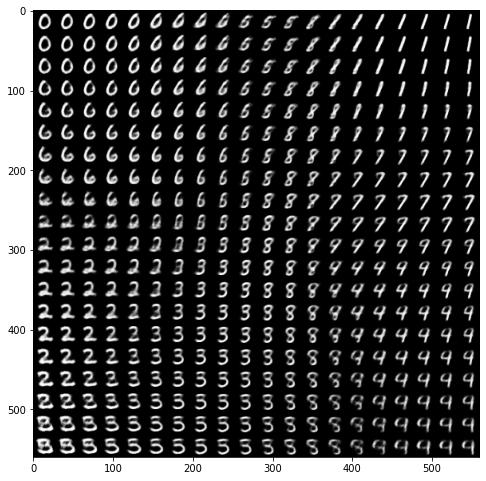

In [0]:
#  output visualization

n = 20
x_limit = np.linspace(-2, 2, n)
y_limit = np.linspace(-2, 2, n)

empty_image = np.empty((28*n, 28*n))

for i, zi in enumerate(x_limit):
  for j, pi in enumerate(y_limit):
    generated_latent_layer = np.array([[zi, pi]]*batch_size)
    # generated_latent_layer = np.random.normal(0,1,size=[batch_size, latent_variable_dimension])
    generated_image = sess.run(Decoder_output_layer, feed_dict = {noise_X : generated_latent_layer})
    empty_image[(n-i-1)*28:(n-i)*28, j*28:(j+1)*28] = generated_image[0].reshape(28,28)

plt.figure(figsize =(8,10))

X,Y = np.meshgrid(x_limit, y_limit)
plt.imshow(empty_image, origin = "upper", cmap = "gray")
plt.grid(False)
plt.show()

(15032, 784)
(15032, 2)


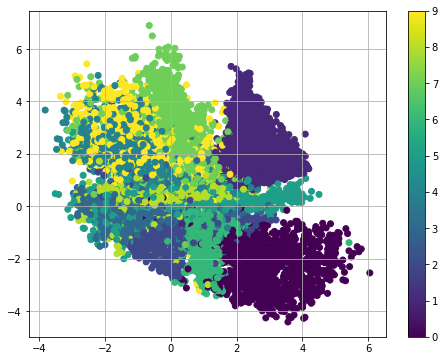

In [0]:
x_sample, y_sample = database.test.next_batch(batch_size+15000)
print(x_sample.shape)

# run of the latent layer, note that the graph is only possible in latent dimension in 2. graphs show the 
# gaussion distribution profile of the latent vector 
interim = sess.run(latent_layer, feed_dict= {image_X : x_sample})
print(interim.shape)

colors = np.argmax(y_sample, 1)

plt.figure(figsize=(8,6))
plt.scatter(interim[:, 0], interim[:, 1], c=colors, cmap='viridis')
plt.colorbar()
plt.grid()

sess.close()
